In [751]:
import pandas
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
import datetime
import seaborn as sns
import datetime
from datetime import timedelta
%matplotlib inline

Programmatically download and load the trip data for September 2015

In [752]:
'Load the data'
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
df = pandas.read_csv(url)

How many rows and columns of data you have loaded?

In [753]:
'Number of rows and columns loaded'
print "Number of rows:", df.shape[0]
print "Number of columns:", df.shape[1]

Number of rows: 1494926
Number of columns: 21


Plot a histogram of the number of the trip distance ("Trip Distance")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e891090>]], dtype=object)

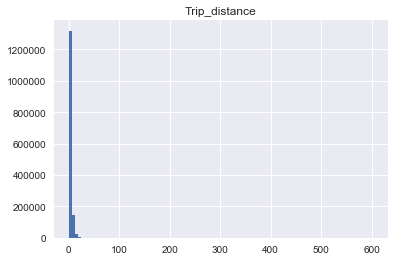

In [754]:
'Histogram plot for trip distance including outliers'
df.hist(column='Trip_distance', bins=100)

In [755]:
'Find the 95th percentile of trip_distance'
perc_95 = numpy.percentile(df.Trip_distance, 95)

In [756]:
'Find the 5th percentile of the trip distance'
perc_5 = numpy.percentile(df.Trip_distance, 5)

In [757]:
'Remove outliers and store the result in a new list'
trip_dist = df[(df.Trip_distance > perc_5 ) & ( df.Trip_distance < perc_95)].Trip_distance

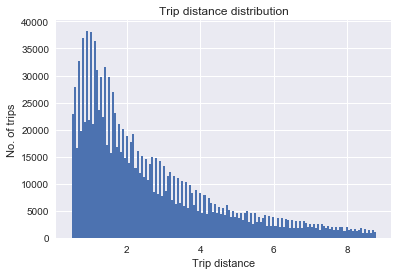

In [758]:
'Plot the histogram after excluding the outliers'
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(trip_dist, bins=150)
plt.title('Trip distance distribution')
plt.xlabel('Trip distance')
plt.ylabel('No. of trips')

Any structure you find and any hypotheses you have about that structure?

The trip distance follows a lognormal distribution or a bell-shaped curve. With its peak values between 0 to 1 miles suggesting that most taxi trips are short ones.

Mean and median trip distance grouped by hour of day

In [759]:
'Convert lpep_pickup_datetime to the appropriate format'
series = df['Trip_distance']
df['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime)
df['Lpep_dropoff_datetime'] = pd.to_datetime(df.Lpep_dropoff_datetime)

In [760]:
'Group the trip distance according to the hour and finde mean and median'
mean_trip_dist = series.groupby(df.lpep_pickup_datetime.dt.hour).mean()
median_trip_dist = series.groupby(df.lpep_pickup_datetime.dt.hour).median()

In [761]:
'Store the hours in a separate list'
hour = mean_trip_dist.index

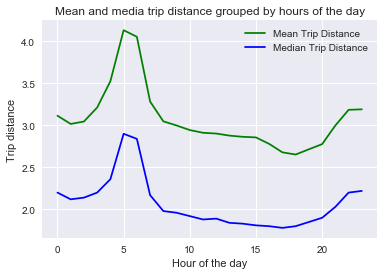

In [762]:
import matplotlib.pyplot as plt
#plot_1 = plt.plot(hour, mean_trip_dist, 'g', hour, median_trip_dist, 'b')
plot_1, = plt.plot(hour, mean_trip_dist, 'g', label='Line 2')
plot_2, = plt.plot(hour, median_trip_dist, 'b', label='Line 1')
plt.legend([plot_1, plot_2], ['Mean Trip Distance', 'Median Trip Distance'])
plt.title('Mean and media trip distance grouped by hours of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Trip distance')
#plt.legend(handles=[], loc=4)

plt.show()

We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips

There are three airports in NYC- JFK, Lagaurdia and Newark. Using the information in the RateCodeID variable we can select the JFK and Newark airport trips. Given more time, I would have liked to play around with the pick up and drop-off co-ordinates to match the locations nearest to the airports.

In [763]:
'Select airport trips by filtering using the RateCodeID=2 for JFK and RateCodeID=3 for Newark'
airport_data = df[(df['RateCodeID'] == 2) | (df['RateCodeID'] == 3)]

In [764]:
'Select the non-airport trips by excluding the airport trips from the dataset'
non_airport_data = df[~df.lpep_pickup_datetime.isin(airport_data['lpep_pickup_datetime'])]

In [765]:
'Number of transactions for NYC airport trips'
print "Number of airport trips: ", airport_data.shape[0]

Number of airport trips:  5552


In [766]:
'Average fare amount of NYC airport trips and non-airport trips'
print "Avergare fare amount of airport trips:", airport_data.Fare_amount.mean()
print "Avergare fare amount of non-airport trips:", non_airport_data.Fare_amount.mean()

Avergare fare amount of airport trips: 48.976945245
Avergare fare amount of non-airport trips: 12.4069261205


In [767]:
'Average trip distance of NYC airport trips and non-airport trips'
print "Average trip distance of airport trips:",airport_data.Trip_distance.mean()
print "Average trip distance of non-airport trips:", non_airport_data.Trip_distance.mean()

Average trip distance of airport trips: 10.378195245
Average trip distance of non-airport trips: 2.94053273812


In [768]:
'Group airport data by hour of the day and storing the count'
airport_count = airport_data.Trip_distance.groupby(airport_data.lpep_pickup_datetime.dt.hour).count()
airport_count = [x for x in airport_count]

In [769]:
'Group non-airport data by hour of the day and storing the count'
non_airport_count = non_airport_data.Trip_distance.groupby(non_airport_data.lpep_pickup_datetime.dt.hour).count()

In [770]:
'Normalizing the non-airport trip count groubed by hour of the day'
norm_non_airport_count = [x/float(non_airport_data.shape[0])*airport_data.shape[0] for x in non_airport_count]

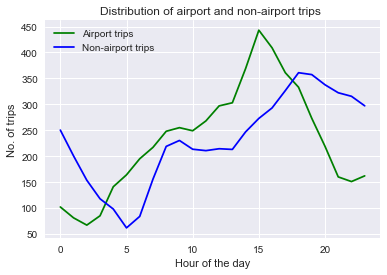

In [771]:
import matplotlib.pyplot as plt
plot_1, = plt.plot(hour, airport_count, 'g', label='Line 2')
plot_2, = plt.plot(hour, norm_non_airport_count, 'b', label='Line 1')
plt.legend([plot_1, plot_2], ['Airport trips', 'Non-airport trips'])
plt.title('Distribution of airport and non-airport trips ')
plt.xlabel('Hour of the day')
plt.ylabel('No. of trips')
plt.show()

About 0.37% of the trips were found to originate or terminate at either JFK or Newark airports, implying that Green Taxis are mostly used for commuting within the city.
By performing some quick manipulations of the airport trips and non-airport trips it was found that on an average airport trips cost four times higher as compared to non-airport trips. This can be explained by the fact that on an average the airport trips are almost 3.5 times longer in terms of duration than the non-airport trips. 
The above figure plots the number of trips per hour for both airport and non-airport(normalized) categories in the dataset. We can observe that there's a trough in the number of airport trips around 2 am and non-airport trips at around 5am. Overall the traffic is low between midnight and early morning hours. However, there's a surge in the traffic oduring the afternoon with peak hours being between 2pm to 6pm. Overall, people are more likely to take taxis for travel during the day as compared to late nights as it coincides with the working hours at most offices.

Build a derived variable for tip as a percentage of the total fare

In [772]:
'Filtering the data with irrelevant records'
df = df[df.Total_amount > 2.5]

Since, minimum amount of a trip is 2.5 , all the records with total amount < 2.5 are filtered from the dataset to keep relevant records

In [773]:
'Derived variable for tip percentage'
df['Tip_percentage'] = df.Tip_amount/df.Total_amount*100

In [774]:
df.Tip_percentage.describe()

count    1.487749e+06
mean     6.666013e+00
std      8.875859e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64

Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample

By observing the characteristics of the Tip_percentage variable, it can be noted that a lot of values must be 0 as the 25th and 50th percentile are zero and also the mean is less. Hence, let's find out the percentage of transactions that received a tip.

In [775]:
'Percentage transactions that received tips from customers'
print "Transactions that received tips:", (float(df[df.Tip_percentage != 0].shape[0])/ float(df.shape[0]))*100, '%'

Transactions that received tips: 40.5122772726 %


Since, only 40% of the transactions received tips we can think about building our model in two phases. We first need to build a classifier that can predict if a transaction would receive a tip or not and then build a regression model for the tips that were predicted with tips by the classifier. 
Some of the factors that might affect a customer paying a tip could be the duration of the trip, whether the customer travelled on a weekday (they could be in a hurry or more stressed) or they travelled on a weekend (when they were more relaxed and patient). Likewise, it could also depend on the which hours during the day the trip occurred or the day of the month or even the speed with which the driver was driving (if he was over-speeding, driving too slow or responsibly). We do not have these exact variables in the dataset but we can derive these variables by other features such as pick-up and drop-off times, trip distance etc. We aso need to create a target variable-'Tip?' for our classifier that assumes a value of 1 if the transaction received a tip or 0 otherwise.

In [776]:
'Creating new features or derived variables'
df['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime)
df['Lpep_dropoff_datetime'] = pd.to_datetime(df.Lpep_dropoff_datetime)
df['Hour_of_day'] = df.lpep_pickup_datetime.dt.hour
df['Day_of_week'] = df.lpep_pickup_datetime.dt.dayofweek
df['Day_of_month'] = df.lpep_pickup_datetime.dt.day
df['Tip?'] = (df.Tip_percentage > 0.0)*1
time_interval = df.Lpep_dropoff_datetime - df.lpep_pickup_datetime
df['Trip_duration'] = [x.total_seconds()/float(60*60) for x in time_interval]
df['Trip_speed'] = df['Trip_distance']/df['Trip_duration']
# Replacing NaN and inf values with the mean value of speed
indices_speed = df[(df.Trip_speed.isnull()) | (df.Trip_speed > 200.0)].index
mean_valid_speed = df[~((df.Trip_speed.isnull()) | (df.Trip_speed > 200))].Trip_speed.mean()
df.loc[indices_speed, 'Trip_speed'] = mean_valid_speed

In [779]:
'Splitting the data set into two parts based on Tip percentage being zero or non-zero'
df_tip = df[df.Tip_percentage > 0.0]
df_non_tip = df[df.Tip_percentage == 0]

We now perform data exploration and visualizarions to explore the features and the relationship between variables below.

In [780]:
print df_tip.Payment_type.value_counts()

1    602718
2         2
4         1
Name: Payment_type, dtype: int64


In [781]:
print df_non_tip.Payment_type.value_counts()

2    779374
1     98215
3      3920
4      3447
5        72
Name: Payment_type, dtype: int64


Since, it can be seen from the above results, 99.9% of the payments that received tips were through credit cards while 87% of the transactions for that did not received tips were through cash payments. Hence, credit card payments are more likely to include tips than cash payments. Thus, payment type can be used a feature for our classifier.
Similarly, exploring other variables.

In [782]:
print df_tip.RateCodeID.value_counts()

1    595471
5      4871
2      1588
4       396
3       395
Name: RateCodeID, dtype: int64


In [783]:
print df_non_tip.RateCodeID.value_counts()

1     856148
5      24921
2       2711
3        696
4        516
6         32
99         4
Name: RateCodeID, dtype: int64


RateCodeIDs follow the same kind of distribution for both kinds of trips, hence not a very good feature for classification.

In [784]:
print "Mean trip distance for trips with tips:", df_tip.Trip_distance.mean()
print "Mean trip distance for trips without tips:", df_non_tip.Trip_distance.mean()

Mean trip distance for trips with tips: 3.50570089643
Mean trip distance for trips without tips: 2.61069620396


In [785]:
print "Mean Fare amount for trips with tips:", df_tip.Fare_amount.mean()
print "Mean Fare amount for trips without tips:", df_non_tip.Fare_amount.mean()

Mean Fare amount for trips with tips: 14.2305401006
Mean Fare amount for trips without tips: 11.5233633738


In [786]:
print "Mean passenger count for trips with tips:", df_tip.Passenger_count.mean()
print "Mean passenger count for trips without tips:", df_non_tip.Passenger_count.mean()

Mean passenger count for trips with tips: 1.37146208611
Mean passenger count for trips without tips: 1.37064703038


In [787]:
print "Mean speed for trips with tips:", df_tip.Trip_speed.mean(), 'mph'
print "Mean speed for trips without tips:", df_non_tip.Trip_speed.mean(), 'mph'

Mean speed for trips with tips: 13.5226743984 mph
Mean speed for trips without tips: 12.4797274775 mph


In [788]:
tip_count = df_tip.Trip_distance.groupby(df_tip.lpep_pickup_datetime.dt.hour).count()
tip_count = [x for x in tip_count]
non_tip_count = df_non_tip.Trip_distance.groupby(df_non_tip.lpep_pickup_datetime.dt.hour).count()
norm_non_tip_count = [float(x)/float(df_non_tip.shape[0])*float(df_tip.shape[0]) for x in non_tip_count]

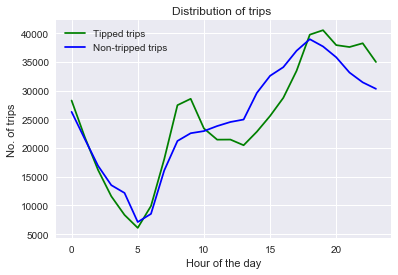

In [793]:
import matplotlib.pyplot as plt
plot_1, = plt.plot(hour, tip_count, 'g', label='Line 2')
plot_2, = plt.plot(hour, norm_non_tip_count, 'b', label='Line 1')
plt.legend([plot_1, plot_2], ['Tipped trips', 'Non-tripped trips'])
plt.title('Distribution of trips ')
plt.xlabel('Hour of the day')
plt.ylabel('No. of trips')
plt.show()

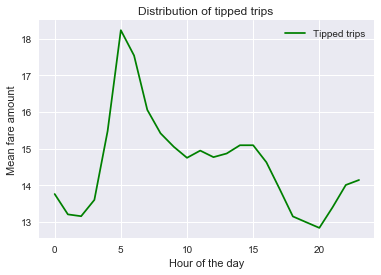

In [795]:
tip_fare_amount = df_tip.Fare_amount.groupby(df_tip.lpep_pickup_datetime.dt.hour).mean()
plot_1, = plt.plot(hour, tip_fare_amount, 'g', label='Line 2')
plt.legend([plot_1], ['Tipped trips'])
plt.title('Distribution of tipped trips ')
plt.xlabel('Hour of the day')
plt.ylabel('Mean fare amount')
plt.show()

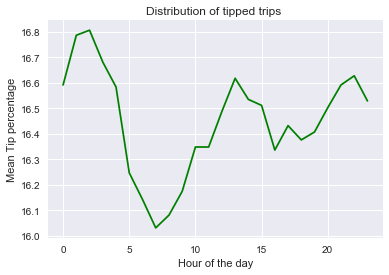

In [796]:
tip_percentage_by_hour = df_tip.Tip_percentage.groupby(df_tip.lpep_pickup_datetime.dt.hour).mean()
plot_1, = plt.plot(hour, tip_percentage_by_hour, 'g', label='Line 2')
plt.title('Distribution of tipped trips ')
plt.xlabel('Hour of the day')
plt.ylabel('Mean Tip percentage')
plt.show()

In [797]:
day_of_week = range(0,7)

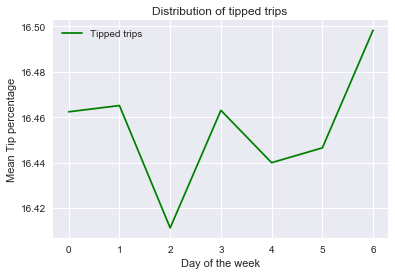

In [373]:
tip_percentage_by_weekday = df_tip.Tip_percentage.groupby(df_tip.lpep_pickup_datetime.dt.dayofweek).mean()
plot_1, = plt.plot(day_of_week, tip_percentage_by_weekday, 'g', label='Line 2')
plt.legend([plot_1], ['Tipped trips'])
plt.title('Distribution of tipped trips ')
plt.xlabel('Day of the week')
plt.ylabel('Mean Tip percentage')
plt.show()

In [798]:
day_of_month = range(0,30)

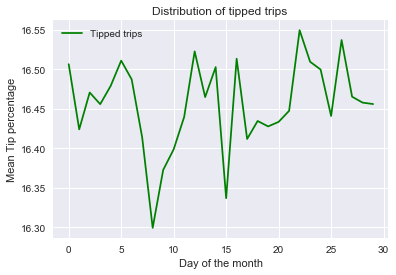

In [799]:
tip_percentage_by_monthday = df_tip.Tip_percentage.groupby(df_tip.lpep_pickup_datetime.dt.day).mean()
plot_1, = plt.plot(day_of_month, tip_percentage_by_monthday, 'g', label='Line 2')
plt.legend([plot_1], ['Tipped trips'])
plt.title('Distribution of tipped trips ')
plt.xlabel('Day of the month')
plt.ylabel('Mean Tip percentage')
plt.show()

In [803]:
'Data Cleaning'
print 'Invalid RateCodeIds:', float(df[~df.RateCodeID.isin([1,2,3,4,5,6])].shape[0])/float(df.shape[0])*100,'%'
print 'Invalid Payment type:', float(df[~df.Payment_type.isin([1,2,3,4,5,6])].shape[0])/float(df.shape[0])*100,'%'

Invalid RateCodeIds: 0.000268862556789 %
Invalid Payment type: 0.0 %


In [804]:
'Replace invalid RateCodeIds with most frequent value = 1'
invalid_indices = df[~df.RateCodeID.isin([1,2,3,4,5,6])].index
df.loc[invalid_indices, 'RateCodeID'] = 1 

In [805]:
print 'Negative passenger count:', float(df[df.Passenger_count < 0].shape[0])/float(df.shape[0])*100,'%'

Negative passenger count: 0.0 %


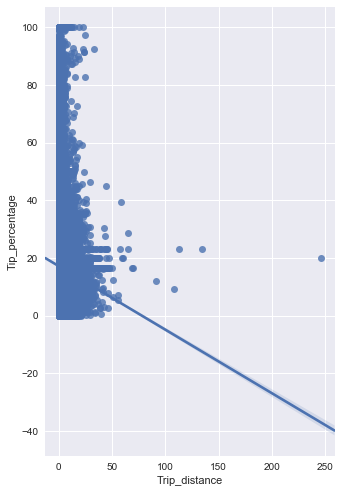

In [806]:
sns.pairplot(df_tip, x_vars= ['Trip_distance'], y_vars='Tip_percentage', size=7, aspect=0.7, kind='reg')

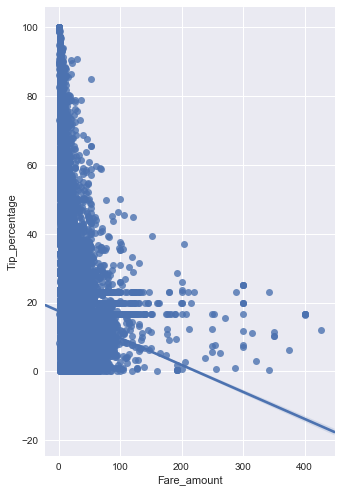

In [536]:
sns.pairplot(df_tip, x_vars= ['Fare_amount'], y_vars='Tip_percentage', size=7, aspect=0.7, kind='reg')

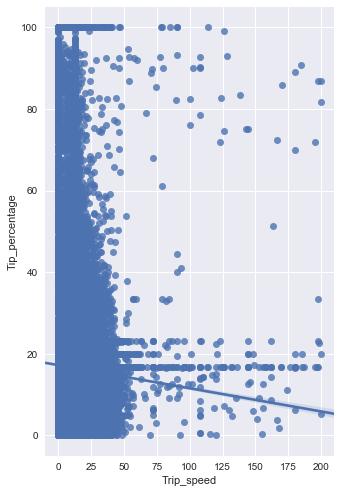

In [807]:
sns.pairplot(df_tip, x_vars= ['Trip_speed'], y_vars='Tip_percentage', size=7, aspect=0.7, kind='reg')

After Data cleaning, exploration and feature engineering, following variables can be selected as feature variables for the classification model- passenger_count, payment_type, hour_of_day, day_of_week, day_of_month

In [808]:
'Classification model for predicting whether a transaction receives a tip or not'
'Put feature variables in a list'
feature_cols = ['Passenger_count', 'Payment_type', 'Hour_of_day', 'Day_of_week', 'Day_of_month']

In [812]:
'Selecting random 100000 records from the original dataset for training the model'
model_data = df.sample(n=100000)
print model_data.shape

(100000, 28)


In [813]:
'Store feature matix in X'
X = model_data[feature_cols]
print X.shape

(100000, 5)


In [815]:
'Store target variable in y'
y = model_data['Tip?']
print y.shape

(100000,)


In [821]:
'Select 1000 records for prediction purposes'
test_data = df.sample(n=1000)
X_test = test_data[feature_cols]
y_test = test_data['Tip?']

In order to select the right model we would first start with a simple classifier model and check its accuracy score. And then we would optimize the model to find best parameters and also compare with other complex models.

In [822]:
'Istantiate a KNN-classifier with 5 neighbours'
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [823]:
'Fit the model with training variables'
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [824]:
'Perform 10 fold cross-validation and find mean accuracy score '
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

In [826]:
print scores.mean()

0.920950074376


Classification accuracy achieved by KNN-classifier with 5 neighbours is 0.9209. So, we know that KNN is a good classifier. We can optimize its parameters by using RandomSearchCV 

In [827]:
from sklearn import metrics

In [828]:
'Finding the best parameter for KNN classifier'
from sklearn.grid_search import RandomizedSearchCV

In [829]:
k_range = range(1,16)
param_dict = dict(n_neighbors=k_range)

In [832]:
rand = RandomizedSearchCV(knn, param_dict, cv=10, scoring='accuracy', n_iter=10, random_state=5)

In [834]:
rand.fit(X,y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          scoring='accuracy', verbose=0)

In [835]:
rand.best_score_

0.92534

In [836]:
rand.best_params_

{'n_neighbors': 11}

Using RandomSearchCV we find that the best parameter = 5 and the accuracy slightly improves using the best parameter.
We would try other classifiers to check if we can improve upon the accuracy.

In [837]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

'Instantiate a decision tree classifier'
dtree = DecisionTreeClassifier()

In [838]:
'Fit the model'
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [839]:
scores = cross_val_score(dtree, X, y, cv=10, scoring='accuracy')
print scores.mean()

0.92906995144


The accuracy obtained (0.929) is again slightly better than with the best KNN model.

In [841]:
from sklearn.ensemble import RandomForestClassifier
'Instantiate a random forest classifier and fit the model to the training data'
rforest = RandomForestClassifier(n_estimators=20)
rforest.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [842]:
print cross_val_score(rforest, X, y, cv=10, scoring='accuracy').mean()

0.931679981463


Again, we see the accuracy improving slightly with random forest classifier (0.9316)

In [844]:
'Baggine trees ensemble methos with 50 trees'
bag = BaggingClassifier(rforest, max_samples=0.5, max_features=1.0, n_estimators=50, oob_score=True)
bag.fit(X,y)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=50, n_jobs=1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [845]:
scores = cross_val_score(bag, X, y, cv=10, scoring='accuracy')
print scores.mean()

0.933869973479


We further observe improvement in inaccuracy but due to shortage of time cannot perform a RandomSearchCV or GridSearchCV for finding the best value of no. of trees for the bagging classifier so randomly select a value of 50. 
We finally select baggingclassifier as our classification model with the scope of improvement and accuracy of 0.934.
We now start building our regression model by comparing the accuracy of linear regression and Gradient Boosting Regression models. We select features like Total_amount, Fare_amount, Trip_distance, Trip_speed and Tolls_amount for the regression model as they representn continuous variables and are likely to affect the Tip percentage.

In [851]:
'Regression model for predicting the Tip percentage'

'Regression model for predicting the Tip percentage'

In [852]:
df.shape

(1487749, 28)

In [866]:
'Selecting 100000 records for training the regressor from the transaction which received tips'
reg_data = df_tip.sample(n=100000)

In [853]:
reg_feature_cols = ['Total_amount', 'Fare_amount', 'Trip_distance', 'Trip_speed', 'Tolls_amount']

In [867]:
X_reg = reg_data[reg_feature_cols]

In [868]:
y_reg = reg_data['Tip_percentage']

In [869]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [870]:
linreg.fit(X_reg, y_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [871]:
scores = cross_val_score(linreg, X_reg, y_reg, cv=10, scoring='neg_mean_squared_error')
print scores

[-14.37365385 -30.94496741 -15.62910939 -17.2656842  -29.19001863
 -14.36457515 -15.75253215 -15.78689872 -18.72667292 -15.7778229 ]


In [872]:
mse_scores = -scores
mse_scores

array([ 14.37365385,  30.94496741,  15.62910939,  17.2656842 ,
        29.19001863,  14.36457515,  15.75253215,  15.78689872,
        18.72667292,  15.7778229 ])

In [873]:
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

4.2897270661939553

The mean root mean squared error is high so we start exploring the Gradient Boosting Ensemble method.

In [874]:
from sklearn.ensemble import GradientBoostingRegressor

boost =  GradientBoostingRegressor()
boost.fit(X_reg, y_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [875]:
scores = cross_val_score(boost, X_reg, y_reg, cv=10, scoring='neg_mean_squared_error')
print scores

[-10.18900291 -10.90064729 -10.42559284 -10.37078608 -10.80857758
 -10.90438681 -10.6993565  -10.06260522 -10.73504373 -10.32592549]


In [876]:
mse_scores = -scores
mse_scores

array([ 10.18900291,  10.90064729,  10.42559284,  10.37078608,
        10.80857758,  10.90438681,  10.6993565 ,  10.06260522,
        10.73504373,  10.32592549])

In [877]:
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

3.2465676487167601

We find improvement in root mean square error by using the ensemble method for the regression model but due to shortage of time we cannot find the best parameters so we stick to a value of 100 estimators.

Finally we combine the two best methods and build our overall model.

We select random 10000 records for testing our predictions

In [895]:
test_data = df.sample(n=10000)

Predict class values by the bagging classifier model

In [896]:
y_pred_class = bag.predict(test_data[feature_cols])

In [897]:
print metrics.accuracy_score(y_pred_class, test_data['Tip?'])

0.9303


Predict the tip percentages by fitting the regression model and multiplying the predicted class values so that the classes predicted as 0 will predict tip percentage as 0.

In [898]:
y_pred_reg = y_pred_class*boost.predict(test_data[reg_feature_cols])

In [899]:
print np.sqrt(metrics.mean_squared_error(test_data['Tip_percentage'], y_pred_reg))

3.67330854689


We can observe that both our classification (0.9303) and regression accuracy (3.673) is good but can be improved further with some more rounds of optimization and model explorations. 

Q 5 Build a derived variable representing the average speed over the course of a trip.

This has already been done for feature engineering purposes. The variable built is Trip_speed

In [900]:
df.Trip_speed.head()

0     0.000000
1     0.000000
2    13.792208
3    10.829268
4     8.926829
Name: Trip_speed, dtype: float64

Perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?


In [904]:
speed = df['Trip_speed']

In [905]:
mean_trip_speed_per_week = speed.groupby(df.lpep_pickup_datetime.dt.week).mean()

In [906]:
mean_trip_speed_per_week

lpep_pickup_datetime
36    13.348522
37    12.673436
38    12.678302
39    13.153892
40    12.486511
Name: Trip_speed, dtype: float64

We can observe that the average trip speeds are materially the same in all 5 weeks of September with the first week and 4th week being a little high on average speed as compared to all other weeks. But the difference is less that 1 mph.